# Introduction

In this notebook we'll attack the MedNIST data set presented in the previous notebook using a deep learning library called _fastai_.

> **Note:** To run this notebook you have to have the fastai library installed. See https://docs.fast.ai for instructions if you want to install on your own computer. If you're using Google Colab, running the notebook will install what's necessary.

In [1]:
# Set this to True if you're using Colab:
colab=False

# Setup

In [2]:
if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()
    from fastbook import *
    NB_DIR = Path.cwd()
    DATA = Path('./gdrive/MyDrive/ColabData')
    DATA.mkdir(exist_ok=True)
    from fastai.vision.all import *
else:
    from fastai.vision.all import *
    NB_DIR = Path.cwd()
    DATA = NB_DIR    

In [3]:
import os, shutil, gc

In [4]:
# If Jedi not working
%config Completer.use_jedi = False

# Load data

In [5]:
path = untar_data("https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1", fname='MedNIST.tar.gz')

In [6]:
path.ls()

(#8) [Path('/home/ubuntu/.fastai/data/MedNIST.tar/HeadCT'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/CXR'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/models'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/Hand'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/AbdomenCT'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/BreastMRI'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/ChestCT'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/README.md')]

In [7]:
fnames = get_image_files(path)
def label_func(x): return x.parent.name
dls = ImageDataLoaders.from_path_func(path, fnames, label_func, valid_pct=0.3)

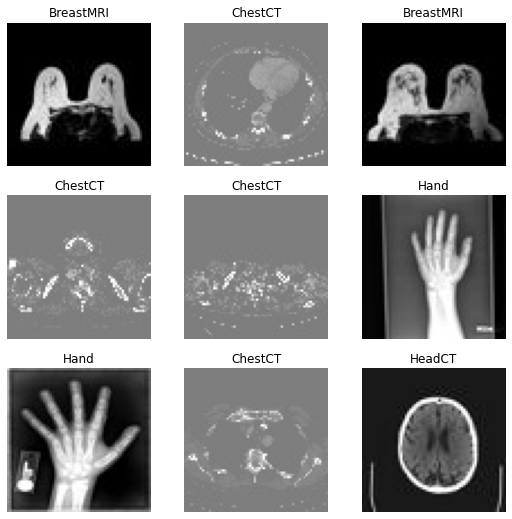

In [8]:
dls.show_batch()

In [9]:
print(f'Number of training images: {len(dls.train_ds)}')
print(f'Number of validation images: {len(dls.valid_ds)}')

Number of training images: 41268
Number of validation images: 17686


# Train a model

Here we create what fastai calls a _learner_. It's created from the above dataloaders and its neural network has a specific architecture (and is pretrained on a large 1.4 million image set from the ImageNet competition). Here we use a `resnet18`. 

In [10]:
learn = cnn_learner(dls, resnet18, pretrained=True, metrics=accuracy)

Let's train it for a bit:

In [11]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.026952,0.002600,0.999095,00:21


epoch,train_loss,valid_loss,accuracy,time
0,0.001727,0.000306,0.999887,00:25


Essentially 100% accurate on the validation data after a minute of training.

# Evaluate model

We can have a look at some predictions:

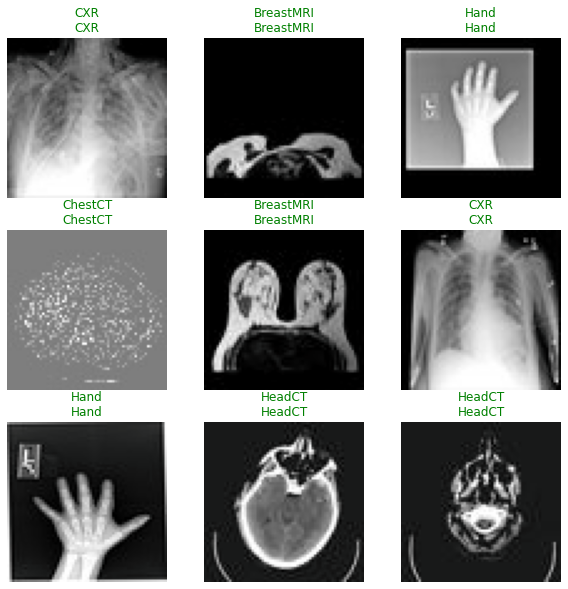

In [12]:
learn.show_results(figsize=(10,10))

...and also the confusion matrix and the images it found most difficult

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

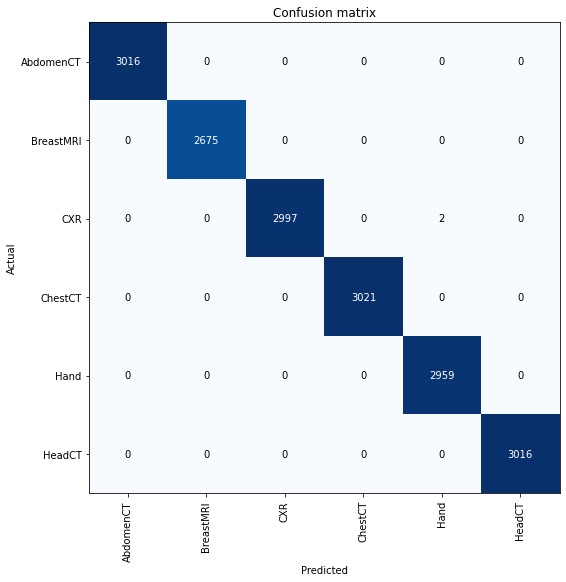

In [14]:
interp.plot_confusion_matrix(figsize=(8,8))

Here are the four images the model misclassified and the ones it was closest to misclassifying, in the order of model confidence:

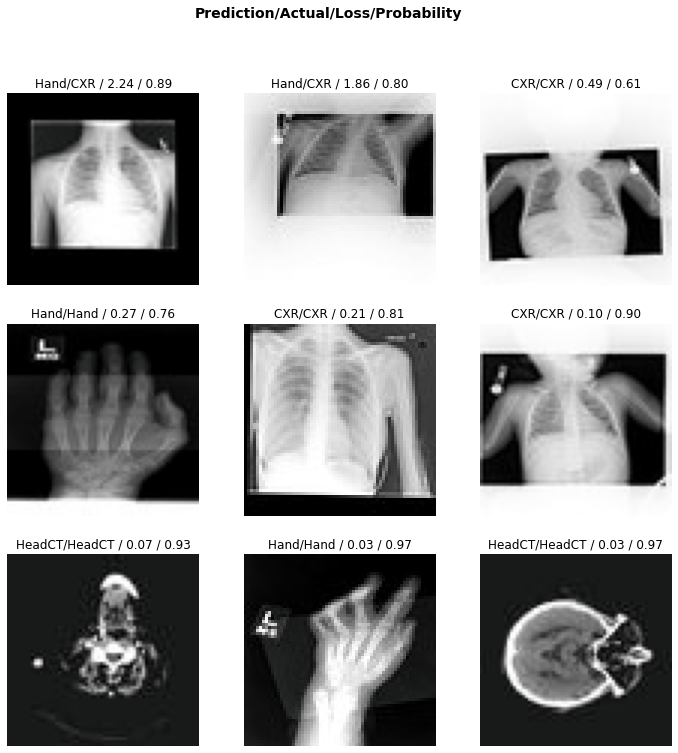

In [15]:
interp.plot_top_losses(9, figsize=(12,12))

We see that the problem is too simple when we're using such powerful methods as above. Let's try another!

In [16]:
# Free up memory:
learn = None
dls = None
gc.collect()
torch.cuda.empty_cache()

# Another example

<img width = 60% src="assets/mura.png">

For a more challenging image classification task, we'll use the MURA data set, available from https://stanfordmlgroup.github.io/competitions/mura:

> "_MURA (musculoskeletal radiographs) is a large dataset of bone X-rays. Algorithms are tasked with determining whether an X-ray study is normal or abnormal._"

> "_Musculoskeletal conditions affect more than 1.7 billion people worldwide, and are the most common cause of severe, long-term pain and disability, with 30 million emergency department visits annually and increasing. We hope that our dataset can lead to significant advances in medical imaging technologies which can diagnose at the level of experts, towards improving healthcare access in parts of the world where access to skilled radiologists is limited._"

To download the data:

> Got to https://stanfordmlgroup.github.io/competitions/mura/ and fill out the registration form to get the download link. 

In [17]:
if colab==True:
    url = None # Put the download link here
    try: 
        !wget $url
        shutil.unpack_archive('MURA-v1.1.zip', extract_dir=DATA)
        !rm MURA-v1.1.zip
        DATADIR = DATA
    except: 
        print("Did you add the download link?")
        raise Exception
else:   
    # Point this to where you downloaded the zip file:
    DATADIR = Path('/data-ext-10tb/ubuntu/MURA')

In [18]:
(DATADIR).ls()

(#4) [Path('/data-ext-10tb/ubuntu/MURA/model.pth'),Path('/data-ext-10tb/ubuntu/MURA/MURA-v1.1'),Path('/data-ext-10tb/ubuntu/MURA/models'),Path('/data-ext-10tb/ubuntu/MURA/MURA-v1.1.zip')]

In [19]:
if not os.path.exists(DATADIR/'MURA-v1.1'):
    shutil.unpack_archive(DATADIR/'MURA-v1.1.zip', extract_dir=DATADIR)

In [20]:
MURA = DATADIR

In [21]:
train_studies = pd.read_csv(MURA/'MURA-v1.1'/'train_labeled_studies.csv', 
                            header=None, names=['study', 'label'])
train_images = pd.read_csv(MURA/'MURA-v1.1'/'train_image_paths.csv', 
                           header=None, names=['image'])

val_studies = pd.read_csv(MURA/'MURA-v1.1'/'valid_labeled_studies.csv', 
                          header=None, names=['study', 'label'])
val_images = pd.read_csv(MURA/'MURA-v1.1'/'valid_image_paths.csv', 
                         header=None, names=['image'])

In [22]:
train_studies.head()

,study,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [23]:
train_images.head()

,image
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [24]:
val_studies.head()

,study,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_positive/,1


In [25]:
val_images.head()

,image
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png


We'll add a column containing the labels extracted from the filenames (_positive / negative_):

In [26]:
def label_func(image):
        study = "/".join(image.split("/")[:-1]) + '/'
        if 'train' in study:
            return int(train_studies.loc[train_studies.study==study].label.values)
        elif 'valid' in study:
            return int(val_studies.loc[val_studies.study==study].label.values)
        else:
            raise Exception

In [27]:
train_images['label'] = train_images['image'].apply(label_func)

In [28]:
val_images['label'] = val_images['image'].apply(label_func)

In [29]:
train_images.head()

,image,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,1


Combine all the images into one data frame, marking what's for training and what's for validation:

In [30]:
train_images['is_valid'] = False
val_images['is_valid'] = True

df = pd.concat([train_images, val_images])

In [31]:
df.head()

,image,label,is_valid
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,1,False
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,1,False
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,1,False
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,1,False
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,1,False


We save the results to file to not have to repeat the computation if we get back to the notebook later:

In [32]:
df.to_csv(MURA/'MURA-v1.1'/'mura_df.csv', index=None)

## Create a dataloader

In [33]:
df = pd.read_csv(MURA/'MURA-v1.1'/'mura_df.csv')

We'll do some transformations of the data as in the PyTorch notebook. The rotation and flips are examples of **data augmentation**. By randomly changing the images by rotation and left-right horisontal flips while keeping their labels one can in a sense create "extra" training data. And also make the trained model more robust for those transformations. 

In [34]:
item_tfms = Resize(600, method='pad', pad_mode='zeros')

batch_tfms = [Resize(512, method='pad', pad_mode='zeros'), Flip(), Zoom(),
              Contrast(), Rotate(max_deg=20), Normalize.from_stats(*imagenet_stats)]

db = DataBlock(blocks=[ImageBlock(cls=PILImageBW), CategoryBlock()], 
                get_x = ColReader('image', pref=MURA),
                get_y = ColReader('label'),
                splitter=ColSplitter('is_valid'),
                item_tfms=item_tfms,
                batch_tfms=batch_tfms
              )

In [35]:
dls = db.dataloaders(df, bs=64)

In [36]:
print(f'Number of training images: {len(dls.train_ds)}')
print(f'Number of validation images: {len(dls.valid_ds)}')

Number of training images: 36808
Number of validation images: 3197


Here are a few images from one batch (batch size is set to 64, these are 6 of them chosen at random).

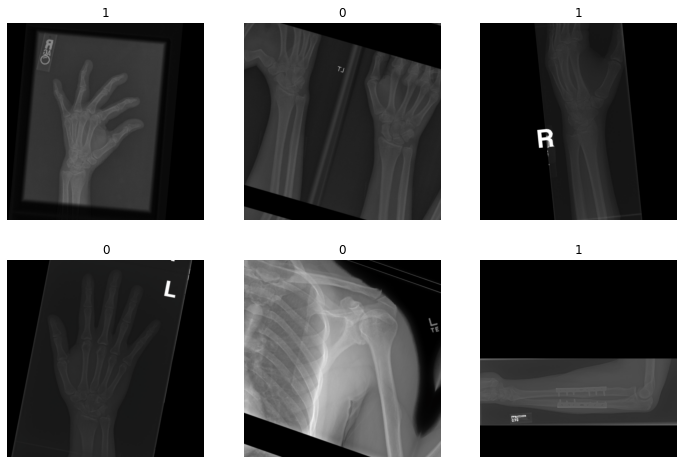

In [37]:
dls.show_batch(max_n=6, figsize=(12,8))

We can take a look at some data augmentation results for a single image:

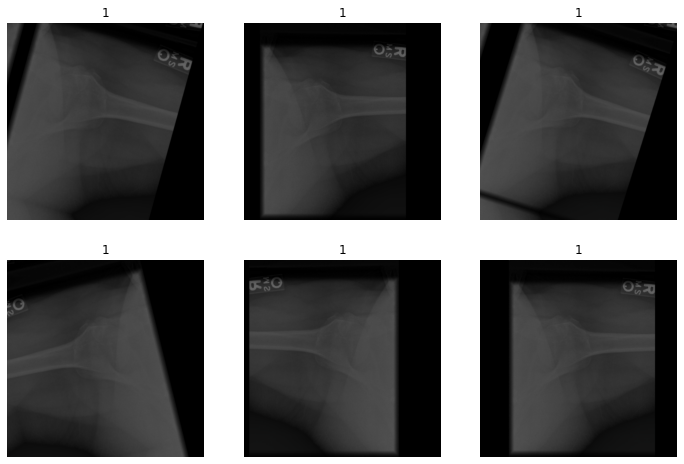

In [38]:
dls.show_batch(max_n=6, figsize=(12,8), unique=True)

> Data augmentation is in general a topic worth thinking hard about each time you face a new data set. Certain transformations may be very important to include as data augmentation (to increase raw model performance or make the model more invariant to certain transformations), others should not be included as they can be completely unrealistic or change what the label of the image should be.

We create a learner as above.

In [39]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy, CohenKappa()]).to_fp16()

In [ ]:
_, lr = learn.lr_find(suggestions=True)

In [ ]:
lr

In [ ]:
#learn.fine_tune(10, base_lr=lr)

In [ ]:
#learn.save(MURA/'model')

This takes some time, so we'll rather load the results I got from running the above training ahead of time:

<img src="assets/mura-training.png">

In [40]:
learn = learn.load(MURA/'model')

## Evaluating the model

Here are a few predictions on validation data:

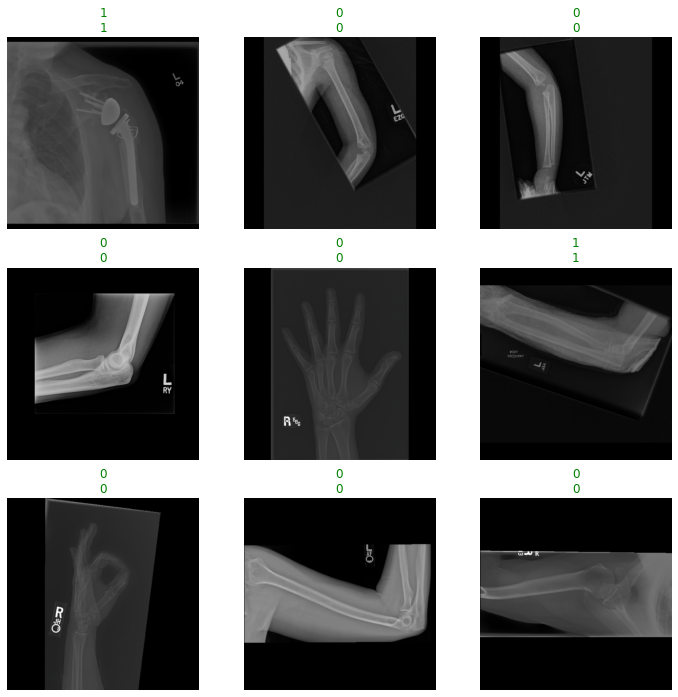

In [41]:
learn.show_results(figsize=(12,12))

In [42]:
interp = ClassificationInterpretation.from_learner(learn)

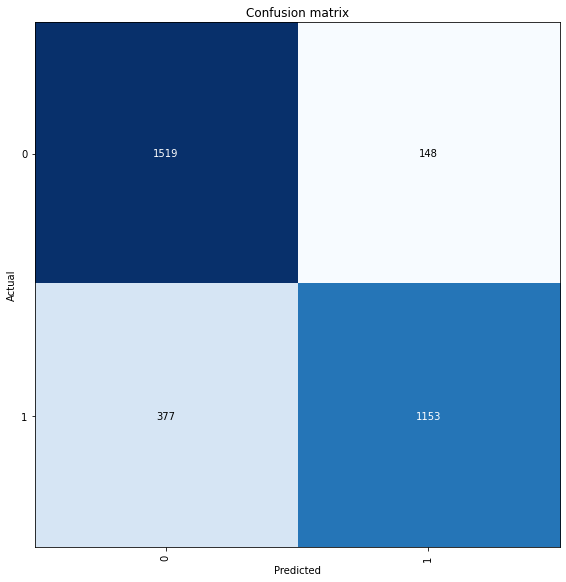

In [43]:
interp.plot_confusion_matrix(figsize=(8,8))

These are the images the model was most confident on, while also incorrect. I.e. in some sense the worst mistakes:

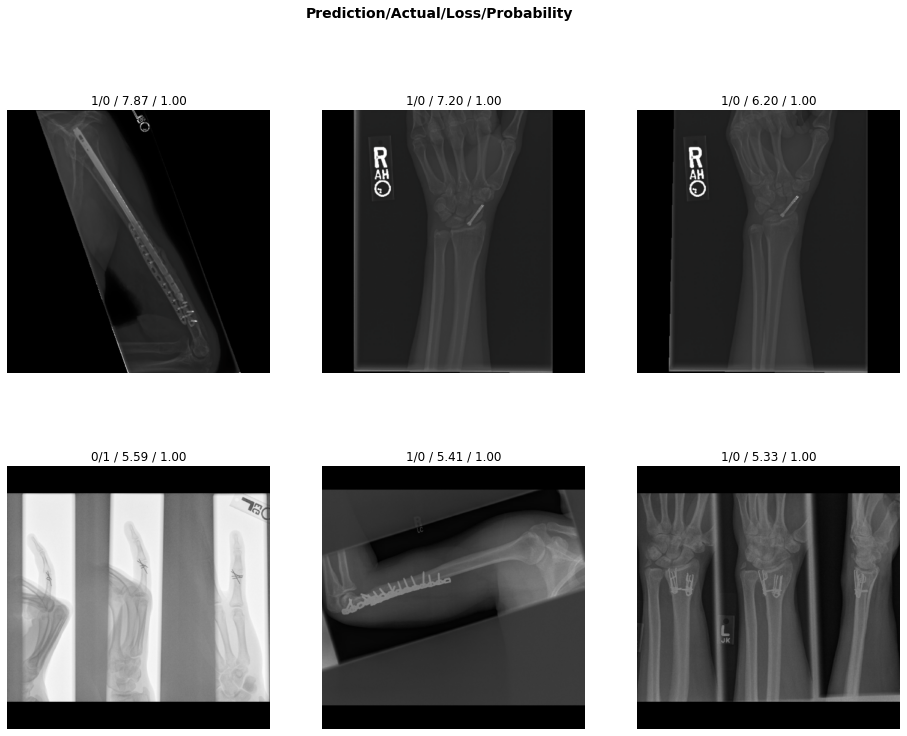

In [44]:
interp.plot_top_losses(6, figsize=(16,12))

## Make study-level predictions

Note that it doesn't a lot of sense great sense to use the labels assigned to studies as labels on the individual images in a study, as above. _A study can indicate an abnormality even if there are images in the studies with no findings._

By taking this into account, one could design better models. I.e. setups for _multi-view_ image classification. 

However, keeping things simple, let's just make study-level predictions based on the above model's predictions on the images of a study. 

We can "vote" on study predictions by aggregating the predictions for each individual image in the study. For example by computing the mean or by marking a study as 'abnormal' if at least one image in the study is predicted as 'abnormal'. The latter will likely result in fewer false negatives, as not all images may show any abnormality even if it's there. 

This can be achieved by the below function:

In [45]:
import ast
def predict_study(studyID, agg='mean'):
    preds = []
    relevant = val_df.loc[val_df.study == studyID]
    imgs = relevant['image'].values[0]
    if imgs == str(imgs):
        imgs = ast.literal_eval(relevant['image'].values[0])
    for img in imgs:
        img = MURA/img
        pred = learn.predict(img)[0]
        preds.append(int(pred))
    if agg == 'max':
        if sum(preds)>=1: return 1
        else: return 0
    elif agg == 'mean':
        if np.mean(preds)>=0.5: return 1
        else: return 0
    else: 
        print("agg must be either max or mean")
        raise Exception

Let's make a study-level dataframe from the validation images:

In [46]:
val_images.head()

,image,label,is_valid
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,1,True
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,1,True
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,1,True
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,1,True
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,1,True


In [47]:
val_df = val_images.copy()
val_df.drop('is_valid', axis=1, inplace=True)

In [48]:
def get_study(imgfn):
    return "_".join(imgfn.split("/")[3:-1])

def get_kind(imgfn):
    return imgfn.split("/")[2]

In [49]:
val_df['study'] = val_df.image.apply(get_study)
val_df['kind'] = val_df.image.apply(get_kind)

In [50]:
val_df.head()

,image,label,study,kind
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,1,patient11185_study1_positive,XR_WRIST
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,1,patient11185_study1_positive,XR_WRIST
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,1,patient11185_study1_positive,XR_WRIST
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,1,patient11185_study1_positive,XR_WRIST
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,1,patient11186_study1_positive,XR_WRIST


In [51]:
# Combine all the images belonging to a single study
val_df = (val_df.groupby(['study', 'kind'])
          .agg({'image': lambda x: x.tolist(),'label':'max'})
          .reset_index())

In [52]:
val_df.head()

,study,kind,image,label
0,patient11185_study1_positive,XR_WRIST,"[MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png, MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png, MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png, MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png]",1
1,patient11186_study1_positive,XR_ELBOW,"[MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image1.png, MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image2.png, MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image3.png, MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image4.png, MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image5.png]",1
2,patient11186_study1_positive,XR_HUMERUS,"[MURA-v1.1/valid/XR_HUMERUS/patient11186/study1_positive/image1.png, MURA-v1.1/valid/XR_HUMERUS/patient11186/study1_positive/image2.png]",1
3,patient11186_study1_positive,XR_SHOULDER,"[MURA-v1.1/valid/XR_SHOULDER/patient11186/study1_positive/image1.png, MURA-v1.1/valid/XR_SHOULDER/patient11186/study1_positive/image2.png, MURA-v1.1/valid/XR_SHOULDER/patient11186/study1_positive/image3.png]",1
4,patient11186_study1_positive,XR_WRIST,"[MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png, MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image2.png]",1


We can run the above function on all the studies in the validation data set and insert the results in the above dataframe as follows:

In [ ]:
# The below computation takes some time... We can rather load the precomputed results:
val_df = pd.read_csv(NB_DIR/'data'/'mura-val-results.csv')

In [54]:
%%capture
val_df['pred_dx'] = val_df.study.apply(partial(predict_study, agg='mean'))

In [55]:
#val_df.to_csv(NB_DIR/'data'/'mura-val-results.csv', index=None)

In [57]:
val_df.head()

,study,kind,image,label,pred_dx
0,patient11185_study1_positive,XR_WRIST,"['MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png', 'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png', 'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png', 'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png']",1,1
1,patient11186_study1_positive,XR_ELBOW,"['MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image1.png', 'MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image2.png', 'MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image3.png', 'MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image4.png', 'MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image5.png']",1,1
2,patient11186_study1_positive,XR_HUMERUS,"['MURA-v1.1/valid/XR_HUMERUS/patient11186/study1_positive/image1.png', 'MURA-v1.1/valid/XR_HUMERUS/patient11186/study1_positive/image2.png']",1,1
3,patient11186_study1_positive,XR_SHOULDER,"['MURA-v1.1/valid/XR_SHOULDER/patient11186/study1_positive/image1.png', 'MURA-v1.1/valid/XR_SHOULDER/patient11186/study1_positive/image2.png', 'MURA-v1.1/valid/XR_SHOULDER/patient11186/study1_positive/image3.png']",1,1
4,patient11186_study1_positive,XR_WRIST,"['MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png', 'MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image2.png']",1,1


...then construct the confusion matrix and compute the accuracy and the Cohen Kappa score:

Here's the study-level confusion matrix:

In [58]:
from sklearn.metrics import confusion_matrix
from cm_utils import plot_confusion_matrix

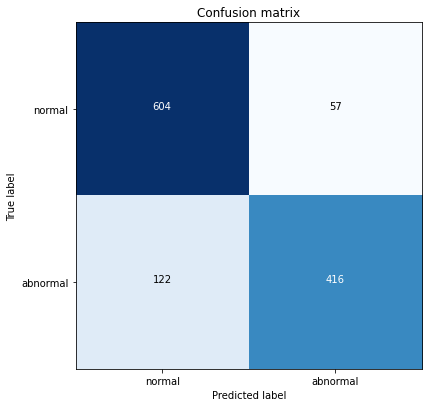

In [59]:
classes=['normal', 'abnormal']
cm = confusion_matrix(val_df.label, val_df.pred_dx)
fig, ax = plt.subplots(figsize=(6,6))
_ = plot_confusion_matrix(cm, classes=classes, ax=ax)

..and the metrics:

In [60]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

In [61]:
accuracy_score(val_df.label, val_df.pred_dx)

0.8507089241034195

In [62]:
cohen_kappa_score(val_df.label, val_df.pred_dx)

0.6948115937495112

We can also have a look at how the model performs for the different kinds of x-rays:

In [63]:
kinds = val_df.kind.unique()
kinds

array(['XR_WRIST', 'XR_ELBOW', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_FOREARM',
       'XR_HAND', 'XR_FINGER'], dtype=object)

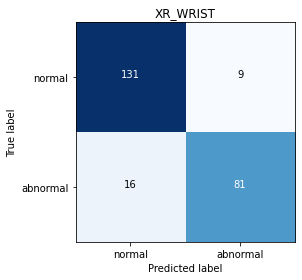

Accuracy: 0.89
Cohen Kappa: 0.78
########################################



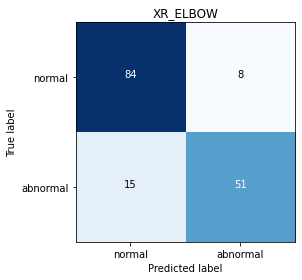

Accuracy: 0.85
Cohen Kappa: 0.7
########################################



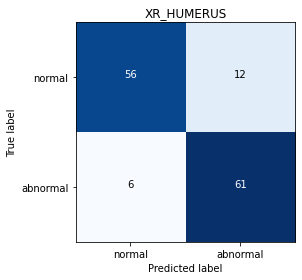

Accuracy: 0.87
Cohen Kappa: 0.73
########################################



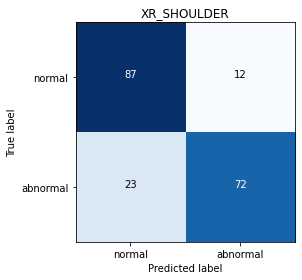

Accuracy: 0.82
Cohen Kappa: 0.64
########################################



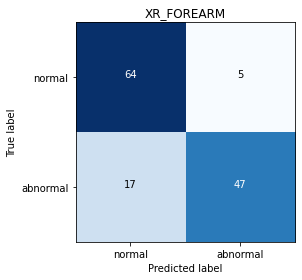

Accuracy: 0.83
Cohen Kappa: 0.67
########################################



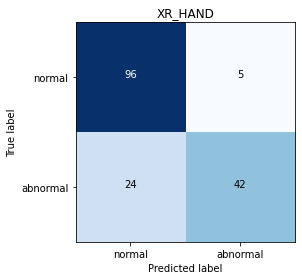

Accuracy: 0.83
Cohen Kappa: 0.62
########################################



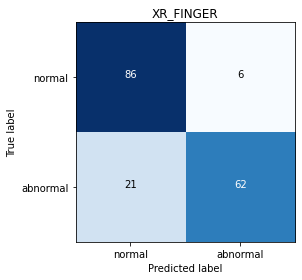

Accuracy: 0.85
Cohen Kappa: 0.69
########################################



In [64]:
for kind in kinds:
    classes=['normal', 'abnormal']
    labels = val_df.loc[val_df.kind==kind].label
    preds = val_df.loc[val_df.kind==kind].pred_dx
    
    cm = confusion_matrix(labels, preds)
    fig, ax = plt.subplots()
    _ = plot_confusion_matrix(cm, classes=classes, ax=ax, title=kind)
    plt.show()
    
    print(f'Accuracy: {np.round(accuracy_score(labels, preds), 2)}')
    print(f'Cohen Kappa: {np.round(cohen_kappa_score(labels, preds), 2)}')
    print("#"*40)
    print()

### Is this a good result?

In [65]:
cohen_kappa_score(val_df.label, val_df.pred_dx)

0.6948115937495112

That depends on what we want to achieve...

An indication can be had by comparing it to other models on the MURA competition leaderboard:

https://stanfordmlgroup.github.io/competitions/mura/

Not too bad for something that could be constructed this easily.

Later, in Part 2, we'll learn several tricks that could be used to improve the results.